## Scrape the Data from Wikipedia

In [1]:
import pandas as pd 
import numpy as np

# df = pd.read_html('https://en.wikipedia.org/wiki/Template:COVID-19_pandemic_data/United_States_medical_cases')
# df[0].to_csv("./covid_wikipedia_tables.csv", sep=',',index=False)

df = pd.read_csv('covid_wikipedia_tables.csv')

## Clean and organize the table

Some of this is hardcoded for the scraping date of 10/4/2020 and will need to be changed if scraped on a later date

In [2]:
## df contains both tables, the first table contains cases
cases = df.copy()

## drop the first row filled with misplaced headers
cases.drop(0, axis=0, inplace=True)

## drop the extra date column
cases.drop('56', axis=1, inplace=True)

## set up the proper column names
col_names = ['Date']
col_names = col_names + list(cases.loc[1])
col_names = [x for x in col_names if str(x) != 'nan']

col_names[56] = 'Confirmed New'
col_names[57] = 'Confirmed Cml'
col_names[58] = 'Deaths New'
col_names[59] = 'Deaths Cml'
col_names[60] = 'Recovered New'
col_names[61] = 'Recovered Cml'
last_col = ['Active Cml']
col_names = col_names + last_col

cases.columns = col_names

## drop rows with extra column headers
rows_to_drop = [1,18,19,51,52,83,84,116,117,148,149,181,182,214,215,246,247,251,252,253,254,255,256,257]

for row in rows_to_drop:
    cases.drop(row, axis=0, inplace=True)
    
## fill nans with 0
cases.fillna(0, inplace=True)

## convert dates from string to datetime
import datetime as dt

cases['Date'] = [dt.datetime.strptime(d + ' 2020', '%b %d %Y') for d in cases['Date']]

cases.reset_index(drop=True, inplace=True)

cases.set_index('Date', inplace=True)

cases=cases.astype(float)

print(len(cases))

233


## Plot Daily Cases and 7-day rolling mean

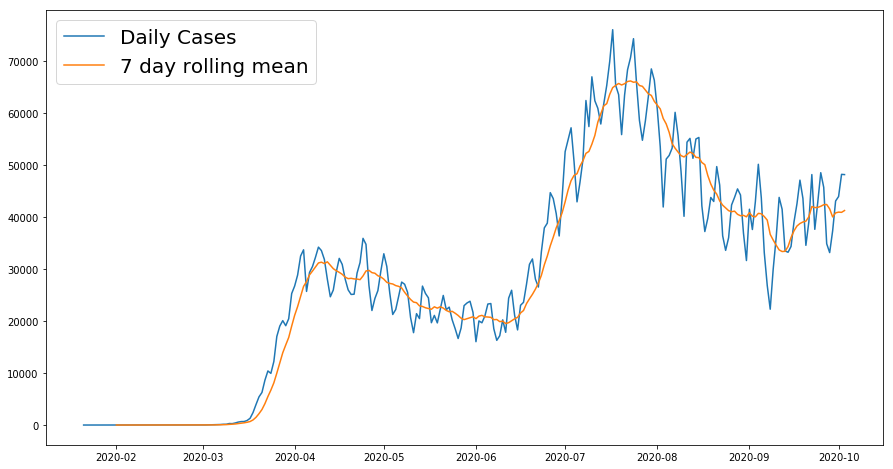

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(15,8))

plt.plot(cases.index.values, cases['Confirmed New'], label = 'Daily Cases')
plt.plot(cases.index.values, cases['Confirmed New'].rolling(7).mean(), label = '7 day rolling mean')
plt.legend(prop={'size': 20})

## Plot Autocorrelation and Partial autocorrelation on a range of lag times

In [4]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

/Users/jcbrooks/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


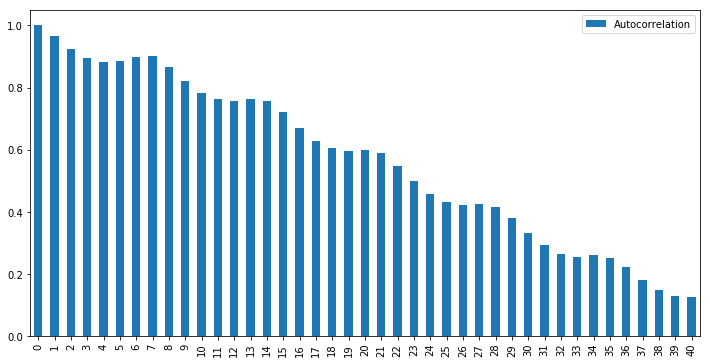

In [5]:
acf_1 = acf(cases['Confirmed New'])
acf_df = pd.DataFrame([acf_1]).T
acf_df.columns = ['Autocorrelation']
acf_df.plot(kind='bar', figsize=(12,6))

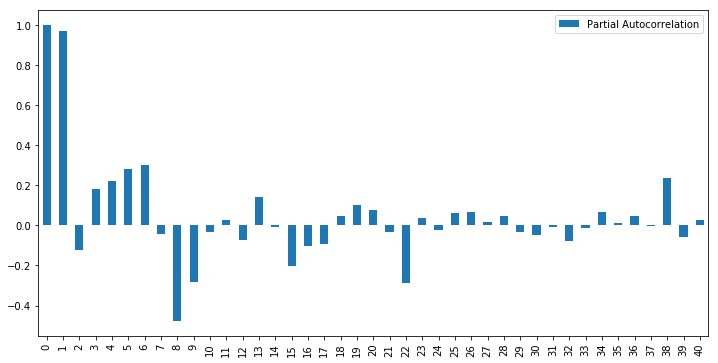

In [6]:
pacf_1 = pacf(cases['Confirmed New'])
pacf_df = pd.DataFrame([pacf_1]).T
pacf_df.columns = ['Partial Autocorrelation']
pacf_df.plot(kind='bar', figsize=(12,6))

## Hyperparameter fitting for ARIMA model

In [7]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [8]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    rmse = np.sqrt(mse)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    print('Something failed', order)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
hyper_fitting = cases

p_values = [5, 6, 7, 8, 9, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(hyper_fitting['Confirmed New'].values, p_values, d_values, q_values)

ARIMA(5, 0, 0) RMSE=5589.053
Something failed (5, 0, 1)
Something failed (5, 0, 2)
ARIMA(5, 1, 0) RMSE=5237.595
ARIMA(5, 1, 1) RMSE=5256.057
Something failed (5, 1, 2)
ARIMA(5, 2, 0) RMSE=6653.239
Something failed (5, 2, 1)
Something failed (5, 2, 2)
ARIMA(6, 0, 0) RMSE=5163.396
Something failed (6, 0, 1)
Something failed (6, 0, 2)
ARIMA(6, 1, 0) RMSE=5321.681
ARIMA(6, 1, 1) RMSE=5071.072
Something failed (6, 1, 2)
ARIMA(6, 2, 0) RMSE=5054.206
ARIMA(6, 2, 1) RMSE=4631.106
Something failed (6, 2, 2)
ARIMA(7, 0, 0) RMSE=5272.359
Something failed (7, 0, 1)
Something failed (7, 0, 2)
ARIMA(7, 1, 0) RMSE=4763.267
ARIMA(7, 1, 1) RMSE=4538.934
Something failed (7, 1, 2)
ARIMA(7, 2, 0) RMSE=4661.965
ARIMA(7, 2, 1) RMSE=4625.146
Something failed (7, 2, 2)
ARIMA(8, 0, 0) RMSE=4744.557
ARIMA(8, 0, 1) RMSE=4507.370
Something failed (8, 0, 2)
ARIMA(8, 1, 0) RMSE=4525.010
ARIMA(8, 1, 1) RMSE=4520.573
Something failed (8, 1, 2)
ARIMA(8, 2, 0) RMSE=4644.568
Something failed (8, 2, 1)
Something failed 

## Train/Test splits and Plots

In [11]:
X = cases['Confirmed New'].values
print(len(X))
# train_size = int(len(X) * 0.7)
train_size = len(X)-60
train, test = X[0:train_size], X[train_size:]
train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
# for t in range(len(test)):

model = ARIMA(history, order=(9,0,0))
model_fit = model.fit(disp=0)
yhats = model_fit.forecast(steps=len(test))

233


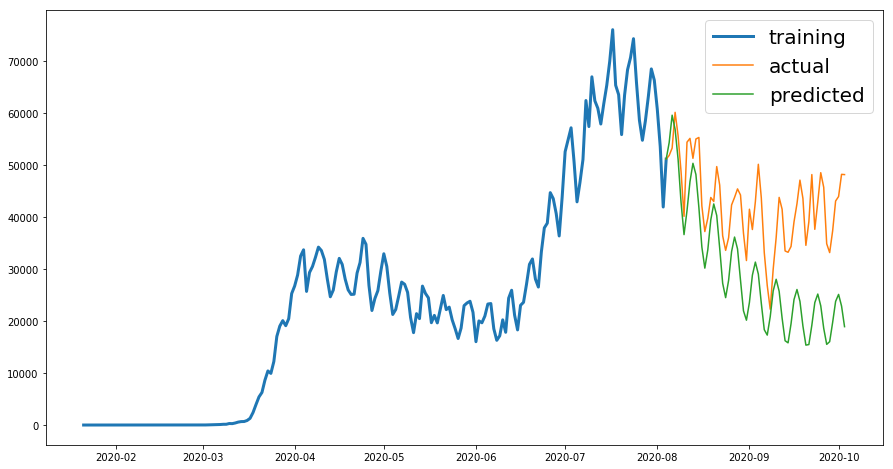

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(15,8))

plt.plot(train_time, train, label='training', linewidth=3)

plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats[0],0,train[-1]), label='predicted')

plt.legend(prop={'size': 20})

In [13]:
def pred_and_plot(days):
    X = cases['Confirmed New'].values

    train_size = len(X)-days
    train, test = X[0:train_size], X[train_size:]
    train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    # for t in range(len(test)):

    model = ARIMA(history, order=(9,0,0))
    model_fit = model.fit(disp=0)
    yhats = model_fit.forecast(steps=len(test))
    
    print('Number of Days predicted: %s' % days)
    
    import matplotlib.pyplot as plt
    %matplotlib inline  
    plt.figure(figsize=(15,8))
    
    plt.plot(train_time, train, label='training', linewidth=3)

    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats[0],0,train[-1]), label='predicted')

    
    plt.legend(prop={'size': 20})
    
    rmse = np.sqrt(mean_squared_error(test, yhats[0]))
    print('RMSE=%.3f' % rmse)
    
    plt.show()
    
    return rmse

Number of Days predicted: 5
RMSE=6229.153


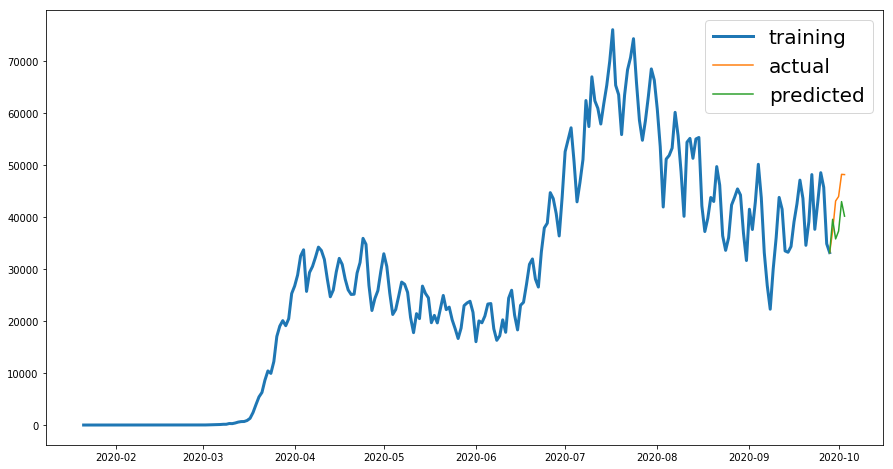

Number of Days predicted: 10
RMSE=4296.731


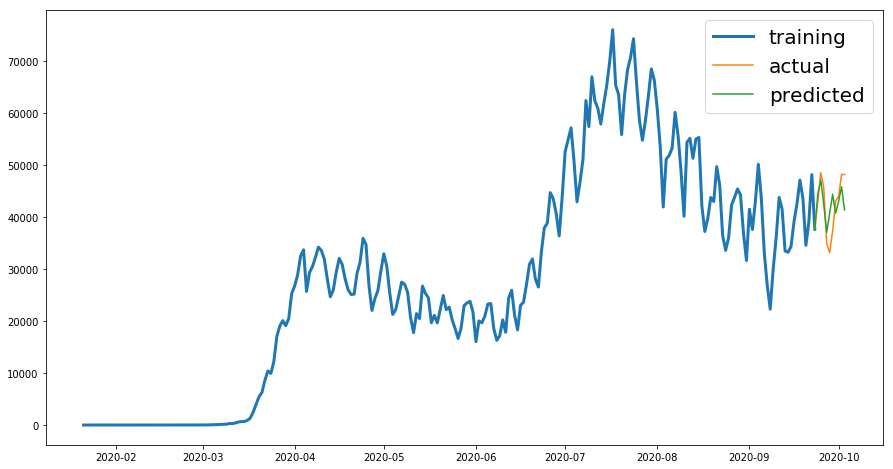

Number of Days predicted: 20
RMSE=10494.971


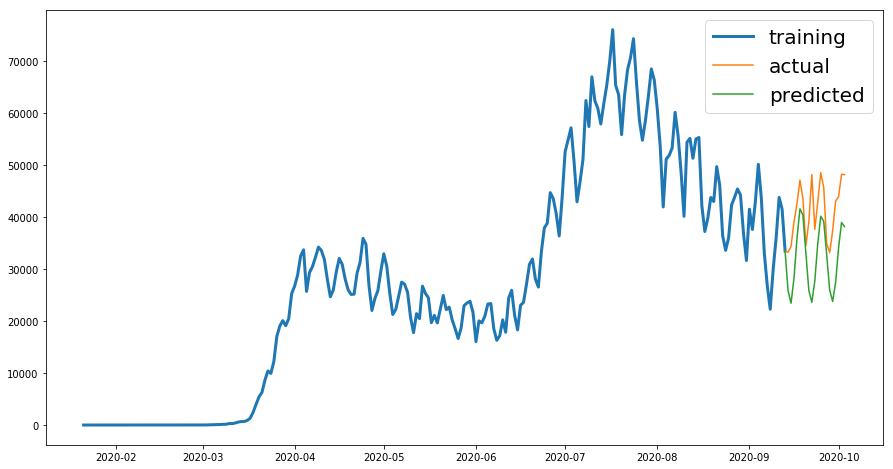

Number of Days predicted: 30
RMSE=7539.214


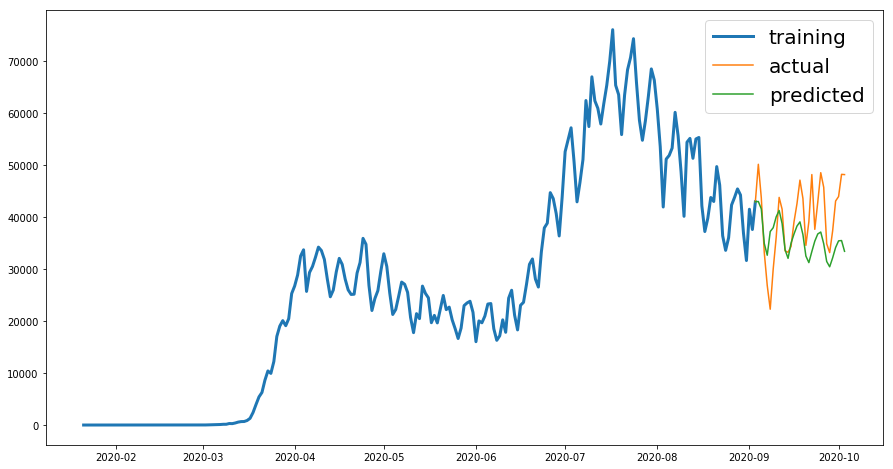

Number of Days predicted: 60
RMSE=15293.537


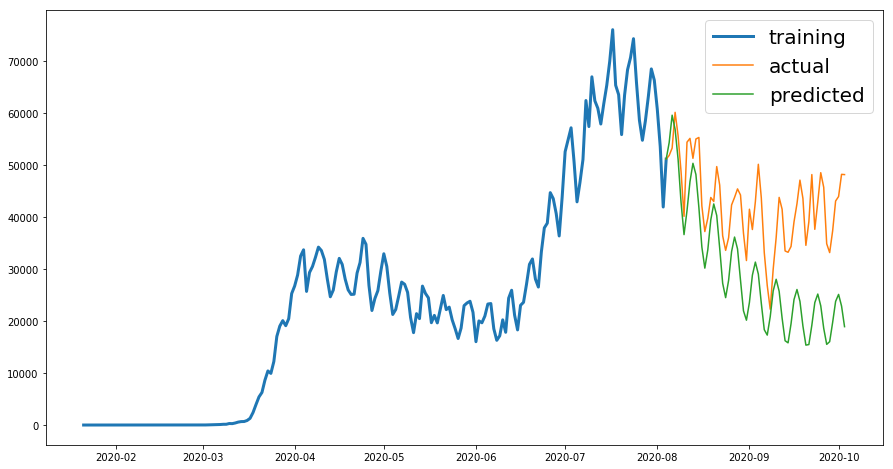

Number of Days predicted: 100
RMSE=16169.768


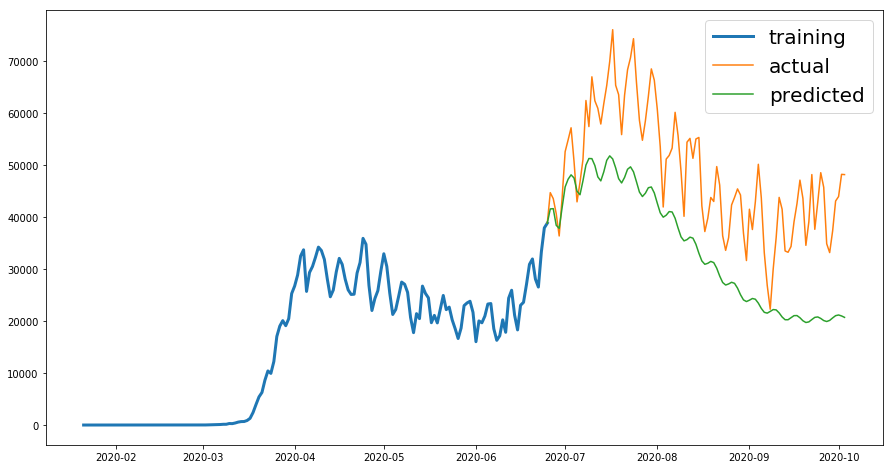

In [14]:
num_days_predicted = [5,10,20,30,60,100]
rmse_plain = []

for days in num_days_predicted:
    rmse = pred_and_plot(days)
    rmse_plain.append(rmse)


## Including Exogenous Variable

#### We have done prediction using the endogenous variable, but many people believe there are important exogenous variables. Many protests erupted across the nation in May, followed by a sharp increase in new Covid case. Let's see if the inclusion of protest data as an exogenous variable can increase the accuracy of our fit.

#### Data is take from https://acleddata.com/special-projects/us-crisis-monitor/

In [15]:
protest_data = pd.read_excel('USA_2020_Sep26.xlsx')
protest_data.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES
0,840,USA4524,4524,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Baltimore City,NaN,Baltimore,39.290,-76.612,1,Fox45 (Baltimore),Subnational,"On 24 May 2020, a caravan of people staged a m...",0
1,840,USA4525,4525,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Williamson,NaN,Marion,37.731,-88.933,1,Southern Illinoisan,Subnational,"On 24 May 2020, nearly 50 people held a ""Patri...",0
2,840,USA4526,4526,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Mahoning,NaN,Youngstown,41.100,-80.650,1,WKBN,Subnational,"On 24 May 2020, an unreported number of people...",0
3,840,USA4527,4527,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),Teachers (United States); Latinx Group (United...,...,Middlesex,NaN,New Brunswick,40.486,-74.452,1,My Central Jersey,Subnational,"On 24 May 2020, more than a dozen vehicles, or...",0
4,840,USA4528,4528,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Essex,NaN,Keene,44.256,-73.792,1,Post-Star,Subnational,"On 24 May 2020, a few people staged a protest ...",0


In [16]:
set(protest_data['EVENT_TYPE'])

{'Battles',
 'Protests',
 'Riots',
 'Strategic developments',
 'Violence against civilians'}

In [17]:
options = ['Protests', 'Riots']

protest_data = protest_data[protest_data['EVENT_TYPE'].isin(options)]
len(protest_data)

13162

In [18]:
protest_num = protest_data.groupby('EVENT_DATE')['ISO'].count().to_frame()

protest_num.columns = ['protests']

df_a = pd.DataFrame(data=np.zeros(100), index=cases.index[:100], columns=['protests'])
df_b = pd.DataFrame(data=np.zeros(7), index=cases.index[-7:], columns=['protests'])

protest_num = pd.concat([df_a, protest_num, df_b])

## Plot of number of protests per day

#### Counting starts 5/24 and ends 9/26

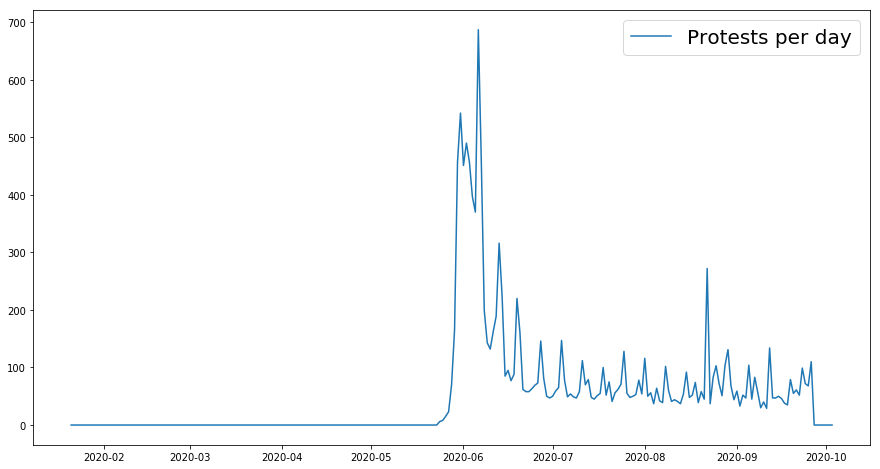

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(15,8))

plt.plot(protest_num.index.values, protest_num['protests'], label = 'Protests per day')
plt.legend(prop={'size': 20})

In [20]:
def evaluate_arima_model_exog(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    train_ex, test_ex = protest_num['protests'][0:train_size], protest_num['protests'][train_size:]
    history = [x for x in train]
    history_ex = [x for x in train_ex]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order, exog=history_ex)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(exog=[test_ex[t]])[0]
        predictions.append(yhat)
        history.append(test[t])
        history_ex.append(test_ex[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [21]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_exog(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model_exog(dataset, order)
                    rmse = np.sqrt(mse)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    print('Something failed', order)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [22]:
p_values = [5, 6, 7, 8, 9, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models_exog(cases['Confirmed New'].values, p_values, d_values, q_values)

ARIMA(5, 0, 0) RMSE=5602.348
Something failed (5, 0, 1)
Something failed (5, 0, 2)
ARIMA(5, 1, 0) RMSE=5233.612
ARIMA(5, 1, 1) RMSE=5239.013
Something failed (5, 1, 2)
ARIMA(5, 2, 0) RMSE=6650.938
ARIMA(5, 2, 1) RMSE=5137.627
Something failed (5, 2, 2)
ARIMA(6, 0, 0) RMSE=5226.762
Something failed (6, 0, 1)
Something failed (6, 0, 2)
ARIMA(6, 1, 0) RMSE=5318.422
ARIMA(6, 1, 1) RMSE=5060.447
Something failed (6, 1, 2)
ARIMA(6, 2, 0) RMSE=5060.562
ARIMA(6, 2, 1) RMSE=4631.680
Something failed (6, 2, 2)
Something failed (7, 0, 0)
Something failed (7, 0, 1)
Something failed (7, 0, 2)
ARIMA(7, 1, 0) RMSE=4758.856
ARIMA(7, 1, 1) RMSE=4533.312
Something failed (7, 1, 2)
ARIMA(7, 2, 0) RMSE=4658.005
Something failed (7, 2, 1)
Something failed (7, 2, 2)
ARIMA(8, 0, 0) RMSE=4745.464
ARIMA(8, 0, 1) RMSE=4530.735
Something failed (8, 0, 2)
ARIMA(8, 1, 0) RMSE=4519.526
ARIMA(8, 1, 1) RMSE=4514.978
Something failed (8, 1, 2)
ARIMA(8, 2, 0) RMSE=4643.966
Something failed (8, 2, 1)
Something failed (8

In [23]:
def pred_and_plot_exog(days):
    X = cases['Confirmed New'].values

    train_size = len(X)-days
    train, test = X[0:train_size], X[train_size:]
    train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
    train_ex, test_ex = protest_num['protests'][0:train_size], protest_num['protests'][train_size:]
    
    history = [x for x in train]
    history_ex = [x for x in train_ex]
    # make predictions
    predictions = list()
    # for t in range(len(test)):

    model = ARIMA(history, order=(8,1,1), exog=history_ex)
    model_fit = model.fit(disp=0)
    yhats = model_fit.forecast(steps=len(test), exog=test_ex)
    
    print('Number of Days predicted: %s' % days)
    
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    %matplotlib inline  
    fig = plt.figure(figsize=(15,8))
    spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[1, 3])
    plt.subplots_adjust(hspace=0.0)

    ax1 = fig.add_subplot(spec[0])
    plt.plot(protest_num.index.values, protest_num['protests'], color='black', label = 'Protests per day')
    plt.legend(prop={'size': 20})
    plt.setp(ax1.get_xticklabels(), visible=False)

    # share x only
    ax2 = fig.add_subplot(spec[1])
    plt.plot(train_time, train, label='training', linewidth=3)
    
    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats[0],0,train[-1]), label='predicted')
    
    plt.legend(prop={'size': 20})
    
    rmse = np.sqrt(mean_squared_error(test, yhats[0]))
    print('RMSE=%.3f' % rmse)
    
    plt.show()
    
    return rmse

## A note before looking at the following plots:

#### We are predicting covid cases using the *actual* protest numbers. If we were being more careful we would use past protest numbers to forecast the protest numbers used to forecast the covid case numbers. As we can see from the protest number plot, from July onward, the protest numbers are fairly stationary, so this should be acceptable for our purposes.

Number of Days predicted: 5
RMSE=5072.864


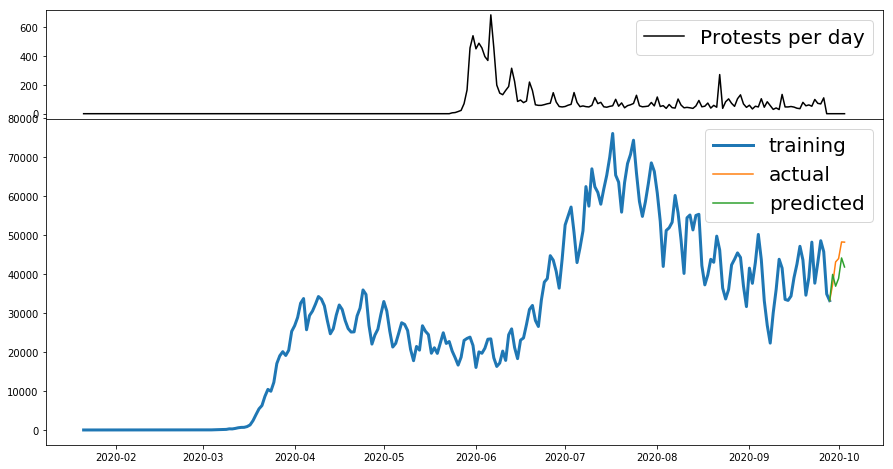

Number of Days predicted: 10
RMSE=4311.817


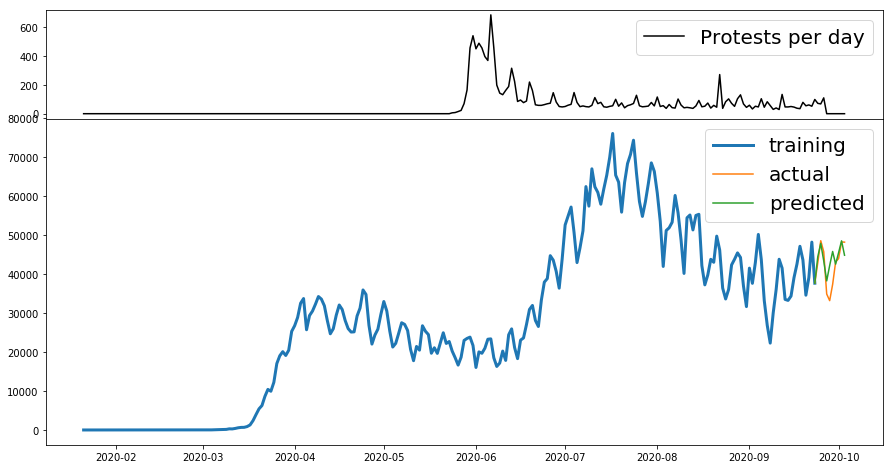

Number of Days predicted: 20
RMSE=10240.928


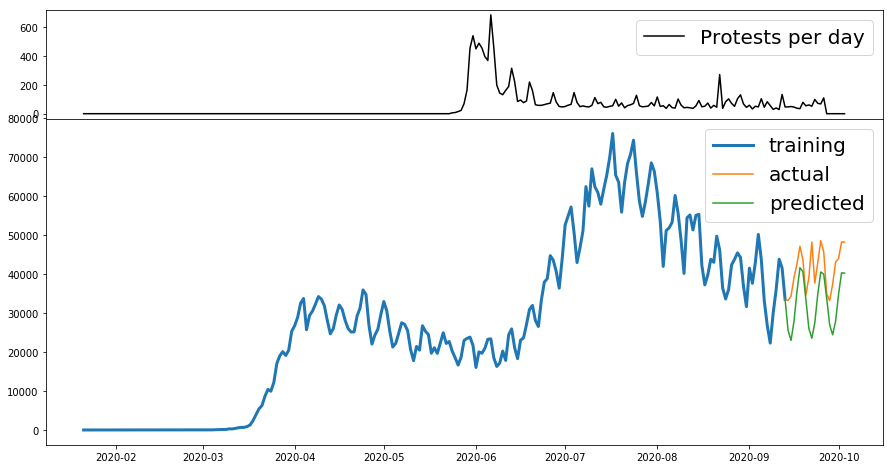

Number of Days predicted: 30
RMSE=5128.382


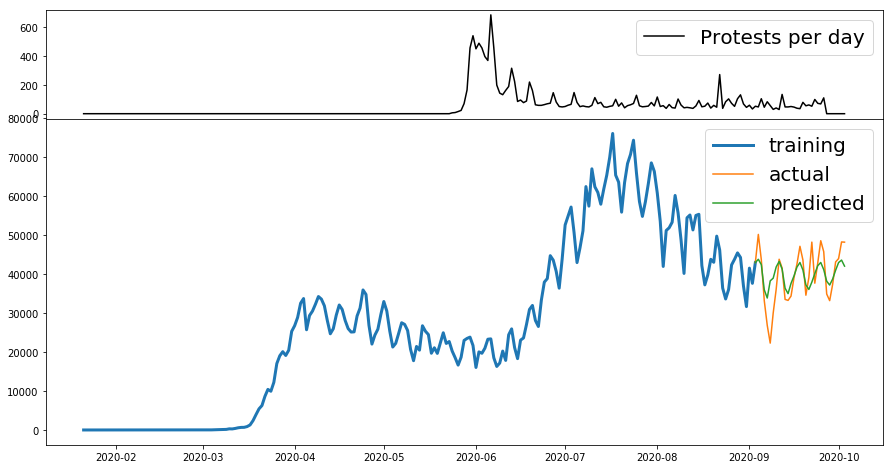

Number of Days predicted: 60
RMSE=4920.370


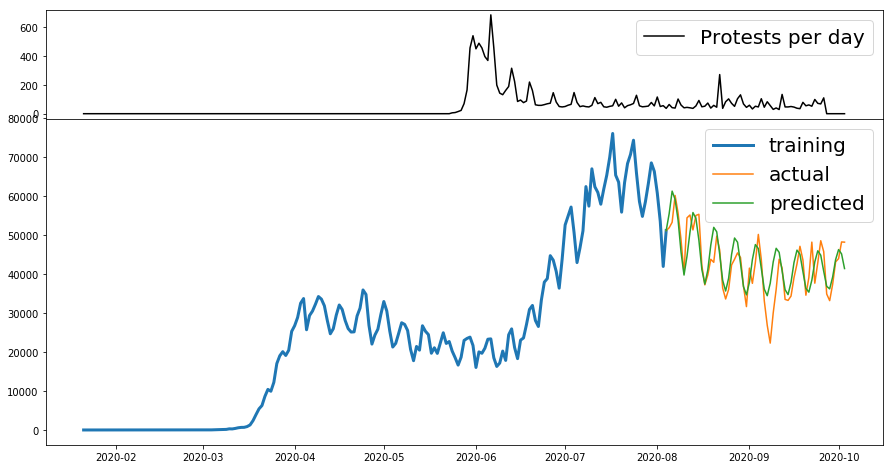

Number of Days predicted: 100
RMSE=36031.491


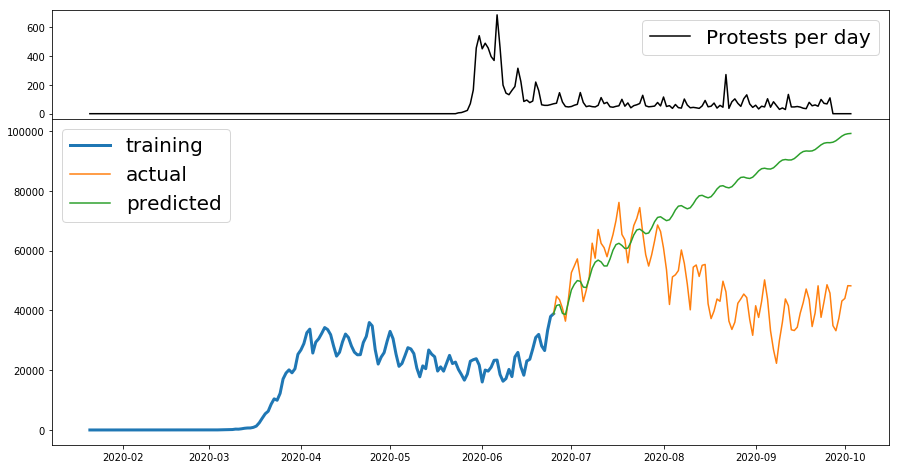

In [24]:
num_days_predicted = [5,10,20,30,60,100]
rmse_exog = []

for days in num_days_predicted:
    rmse = pred_and_plot_exog(days)
    rmse_exog.append(rmse)


## Comparison of Forecasting for "Plain" model vs model with Exogenous Variable

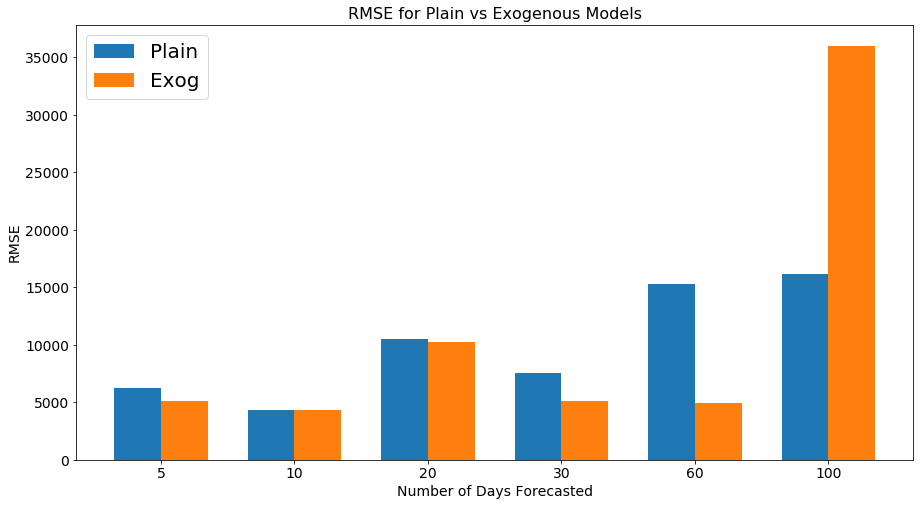

In [25]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline  
fig = plt.figure(figsize=(15,8))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

N = 6
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, rmse_plain, width, label='Plain')
plt.bar(ind + width, rmse_exog, width,
    label='Exog')

plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Number of Days Forecasted', fontsize=14)
plt.title('RMSE for Plain vs Exogenous Models', fontsize=16)

plt.xticks(ind + width / 2, ('5', '10', '20', '30', '60', '100'))
plt.legend(loc='best', prop={'size': 20})

plt.show()

#### We can see from this plot that the model with an included exogenous variable of number of protests improved the fit for 5-60 days. Given the number of days recorded and the rate of change, it's probably not appropriate to be forecasting out 100 days, so we won't worry too much about those computed error terms.

## Can we forecast case numbers for individual states?